In [1]:
# import libraries for eda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import sys
import statsmodels.api as sm

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from time import strptime
from datetime import datetime

data_folderpath = r"data\!Spring_Invitational_2024_data\Datathon_Data" 

In [2]:
def str_to_numeric(s, check_numeric=True, comma_is_dot=False):
    if not isinstance(s, str):
        return s
    s_clean = s.replace("%", "").replace("±", "").replace("(", "").replace(")", "").replace("R", "").replace("P", "")
    
    comma_replace = "." if comma_is_dot else ""
    s_clean = s_clean.replace(",", comma_replace)
    
    if s_clean.isnumeric() or not check_numeric:
        return float(s_clean)
    return s_clean

In [4]:
top_oil_producers = ["Texas", "New Mexico", "Oklahoma", "Colorado", "North Dakota", "Alaska"] # https://www.investopedia.com/financial-edge/0511/top-6-oil-producing-states.aspx

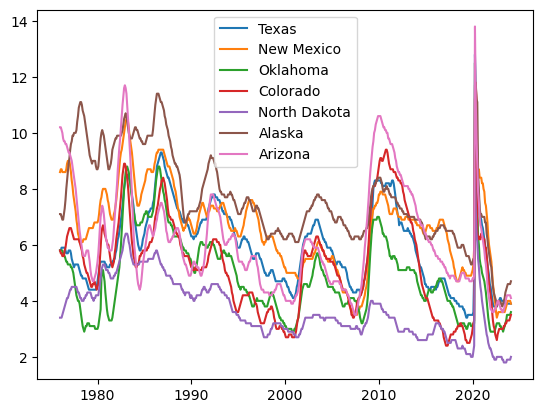

In [147]:
# Source: Bureau of Labor Statistics https://www.bls.gov/

dfs = []
for state in (top_oil_producers + ["Arizona"]):
    df = pd.read_csv(f"data\\employment_data\\{state.lower()}_unemployment.csv")
    df["unemployment rate"] = df["unemployment rate"].apply(lambda s: str_to_numeric(s, False))
    df["Month"] = df["Period"].apply(lambda s: strptime(s, "%b").tm_mon).astype(int)
    df["Quarter"] = ((df["Month"]-1) // 4 + 1).astype(int)
    df["Quarter_Date_Time"] = df.apply(lambda row: datetime(year=row["Year"], month=row["Quarter"]*3 - 2, day=1), axis=1)
    df["datetime"] = df.apply(lambda row: datetime(int(row["Year"]), int(row["Month"]), 1), axis=1)
    df["state"] = state
    dfs.append(df)
    
    plt.plot(df["datetime"], df["unemployment rate"], label=state)
    
unemployment_data = pd.concat(dfs)
    
plt.legend()
plt.show()

In [148]:
oil_and_gas_empl_texas = pd.read_csv("data\\employment_data\\texas_oil_and_gas_extraction.csv")
service_empl_texas = pd.read_csv("data\\employment_data\\texas_service_employees.csv")
minimum_wage_texas = pd.read_csv("data\\employment_data\\texas_minimum_wage.csv")
minimum_wage_texas["Year"] = minimum_wage_texas["DATE"].apply(lambda s: s[:4]).astype(int)

oil_and_gas_empl_texas = oil_and_gas_empl_texas[oil_and_gas_empl_texas["og_employees"] != "."]
service_empl_texas = service_empl_texas[service_empl_texas["service_employees"] != "."]

oil_and_gas_empl_texas["og_employees"] = oil_and_gas_empl_texas["og_employees"].apply(str_to_numeric).astype(float)
service_empl_texas["service_employees"] = service_empl_texas["service_employees"].apply(str_to_numeric).astype(float)

merged_empl_texas = oil_and_gas_empl_texas.merge(service_empl_texas, on="DATE")
merged_empl_texas["ratio"] = merged_empl_texas["og_employees"] / merged_empl_texas["service_employees"]
merged_empl_texas["ratio_diff"] = merged_empl_texas["ratio"].pct_change()
merged_empl_texas["Quarter_Date_Time"] = merged_empl_texas["DATE"].apply(lambda s: datetime.strptime(s, "%Y-%m-%d"))
merged_empl_texas["Year"] = merged_empl_texas["Quarter_Date_Time"].apply(lambda d: d.year)

merged_empl_texas = merged_empl_texas.merge(minimum_wage_texas, on="Year")
merged_empl_texas["min_w_change"] = merged_empl_texas["min_wage"].pct_change()
merged_empl_texas = merged_empl_texas.dropna()

In [149]:
adfuller(merged_empl_texas["ratio"]), adfuller(merged_empl_texas["ratio_diff"])

((-2.180533486222206,
  0.2133863825165837,
  4,
  130,
  {'1%': -3.4816817173418295,
   '5%': -2.8840418343195267,
   '10%': -2.578770059171598},
  -1526.2403028777876),
 (-4.807100489162153,
  5.271024875584382e-05,
  3,
  131,
  {'1%': -3.481281802271349,
   '5%': -2.883867891664528,
   '10%': -2.5786771965503177},
  -608.882134151037))

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

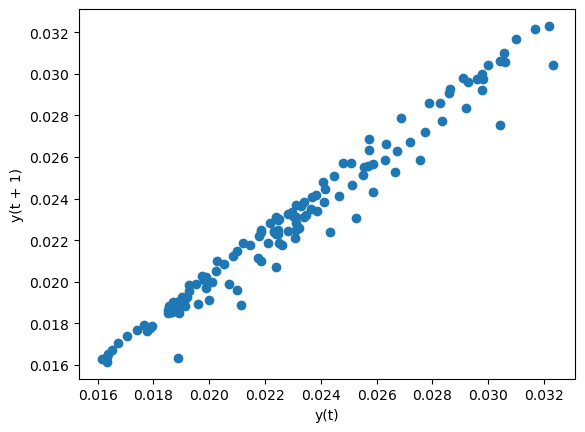

In [150]:
lag_plot(merged_empl_texas["ratio"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

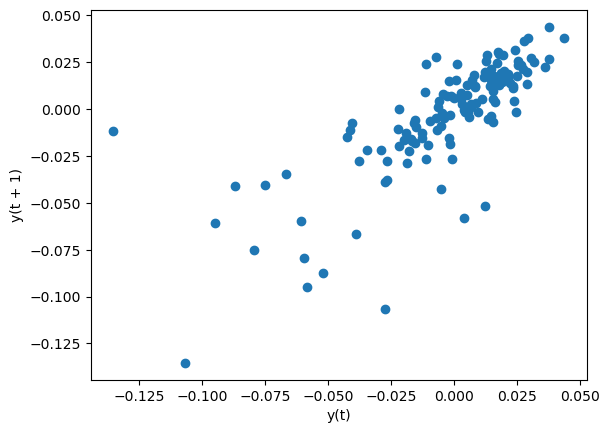

In [151]:
lag_plot(merged_empl_texas["ratio_diff"])

In [33]:
avg_quarterly_unemployment = unemployment_data.groupby(["Quarter_Date_Time", "state"]).agg({"unemployment rate": "mean"}).reset_index()

In [67]:
avg_q_une_texas = avg_quarterly_unemployment[avg_quarterly_unemployment["state"] == "Texas"]
avg_q_une_texas["ur_lag_1"] = avg_q_une_texas["unemployment rate"].shift(1)
avg_q_une_texas["ur_lag_2"] = avg_q_une_texas["unemployment rate"].shift(2)
avg_q_une_texas["ur_lag_3"] = avg_q_une_texas["unemployment rate"].shift(3)

C:\Users\botta\AppData\Local\Temp\ipykernel_1324\459725126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_q_une_texas["ur_lag_1"] = avg_q_une_texas["unemployment rate"].shift(1)
C:\Users\botta\AppData\Local\Temp\ipykernel_1324\459725126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_q_une_texas["ur_lag_2"] = avg_q_une_texas["unemployment rate"].shift(2)
C:\Users\botta\AppData\Local\Temp\ipykernel_1324\459725126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [68]:
avg_q_une_texas

,Quarter_Date_Time,state,unemployment rate,ur_lag_1,ur_lag_2,ur_lag_3
6,1976-01-01,Texas,5.850,NaN,NaN,NaN
13,1976-04-01,Texas,5.875,5.850,NaN,NaN
20,1976-07-01,Texas,5.725,5.875,5.850,NaN
27,1977-01-01,Texas,5.700,5.725,5.875,5.850
34,1977-04-01,Texas,5.300,5.700,5.725,5.875
...,...,...,...,...,...,...
986,2022-07-01,Texas,4.000,3.800,4.025,4.775
993,2023-01-01,Texas,4.025,4.000,3.800,4.025
1000,2023-04-01,Texas,3.925,4.025,4.000,3.800
1007,2023-07-01,Texas,3.900,3.925,4.025,4.000


In [36]:
adfuller(avg_q_une_texas["unemployment rate"])

(-3.6357552118832164,
 0.005113127901647486,
 1,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 213.7171769839871)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

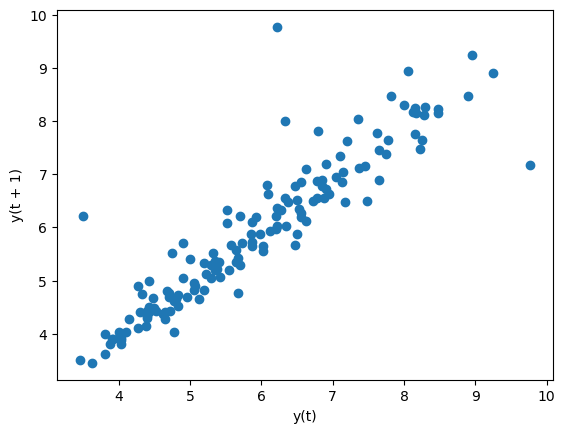

In [136]:
from pandas.plotting import lag_plot 

lag_plot(avg_q_une_texas["unemployment rate"])

In [37]:
# import data

commodities_data_path = data_folderpath + r"/all_commodities.csv"

print(commodities_data_path)

commodities_data = pd.read_csv(commodities_data_path).sort_values("Date_Time")

data\!Spring_Invitational_2024_data\Datathon_Data/all_commodities.csv


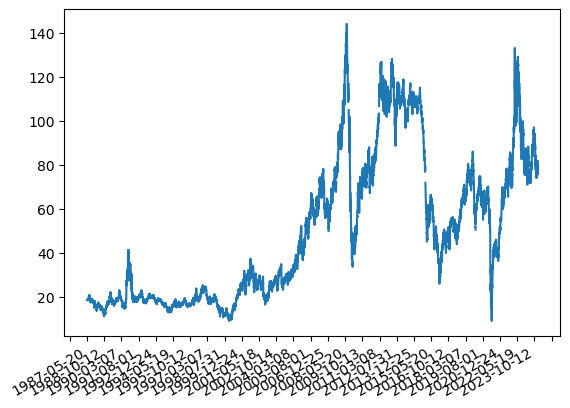

In [38]:
oil_price = commodities_data[commodities_data["Commodity_Simple"] == "BRENT"]

plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.plot(oil_price["Date_Time"], oil_price["Value"])
plt.gcf().autofmt_xdate()
plt.show()

In [39]:
oil_price

,Date_Time,Value,Commodity,Commodity_Simple,Unit
26557,1987-05-20,18.63,Brent Crude Oil,BRENT,Dollars per Barrel
26556,1987-05-21,18.45,Brent Crude Oil,BRENT,Dollars per Barrel
26555,1987-05-22,18.55,Brent Crude Oil,BRENT,Dollars per Barrel
26554,1987-05-25,18.60,Brent Crude Oil,BRENT,Dollars per Barrel
26553,1987-05-26,18.63,Brent Crude Oil,BRENT,Dollars per Barrel
...,...,...,...,...,...
16993,2024-01-16,80.15,Brent Crude Oil,BRENT,Dollars per Barrel
16992,2024-01-17,78.88,Brent Crude Oil,BRENT,Dollars per Barrel
16991,2024-01-18,81.04,Brent Crude Oil,BRENT,Dollars per Barrel
16990,2024-01-19,80.71,Brent Crude Oil,BRENT,Dollars per Barrel


In [65]:
oil_price["Year"] = oil_price["Date_Time"].apply(lambda s: int(s[:4]))
oil_price["Month"] = oil_price["Date_Time"].apply(lambda s: int(s[5:7]))
oil_price["Quarter"] = ((oil_price["Month"]-1) // 4 + 1).astype(int)
oil_price["Quarter_Date_Time"] = oil_price.apply(lambda row: datetime(year=row["Year"], month=row["Quarter"]*3 - 2, day=1), axis=1)
oil_price["log_price"] = np.log(oil_price["Value"])
oil_price["squared_log_diff"] = (oil_price["log_price"].diff())**2
realized_volatility = oil_price.groupby(["Quarter_Date_Time"]).agg({"squared_log_diff": "sum"}).reset_index()

C:\Users\botta\AppData\Local\Temp\ipykernel_1324\1513927547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_price["Year"] = oil_price["Date_Time"].apply(lambda s: int(s[:4]))
C:\Users\botta\AppData\Local\Temp\ipykernel_1324\1513927547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_price["Month"] = oil_price["Date_Time"].apply(lambda s: int(s[5:7]))
C:\Users\botta\AppData\Local\Temp\ipykernel_1324\1513927547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

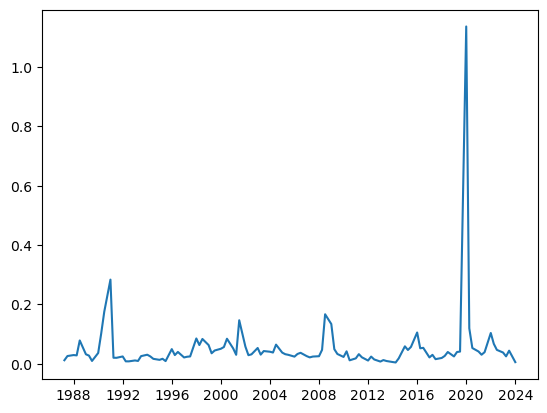

In [41]:
plt.plot(realized_volatility["Quarter_Date_Time"], realized_volatility["squared_log_diff"])

In [54]:
adfuller(realized_volatility["squared_log_diff"])

(-9.318393496818913,
 1.004589874246056e-15,
 0,
 110,
 {'1%': -3.4912451337340342,
  '5%': -2.8881954545454547,
  '10%': -2.5809876033057852},
 -141.67994819971705)

In [106]:
realized_volatility["squared_log_diff_1"] = realized_volatility["squared_log_diff"].shift(1)
realized_volatility["squared_log_diff_2"] = realized_volatility["squared_log_diff"].shift(2)
realized_volatility["squared_log_diff_3"] = realized_volatility["squared_log_diff"].shift(3)
#realized_volatility["squared_log_diff_4"] = realized_volatility["squared_log_diff"].shift(4)

In [107]:
# import data
stocks_path = data_folderpath + r"/all_stocks_and_etfs.csv"

print(stocks_path)

stocks = pd.read_csv(stocks_path).sort_values("Date-Time")

data\!Spring_Invitational_2024_data\Datathon_Data/all_stocks_and_etfs.csv


In [204]:
sp500 = stocks[stocks["Ticker_Symbol"] == "SPY"]

In [205]:
sp500["Year"] = sp500["Date-Time"].apply(lambda s: int(s[:4]))
sp500["Month"] = sp500["Date-Time"].apply(lambda s: int(s[5:7]))
sp500["Quarter"] = ((sp500["Month"]-1) // 4 + 1).astype(int)
sp500["Quarter_Date_Time"] = sp500.apply(lambda row: datetime(year=row["Year"], month=row["Quarter"]*3 - 2, day=1), axis=1)
sp500["log_price"] = np.log(sp500["Close"])
sp500["log_diff_squared"] = ((sp500["log_price"].diff())**2)
sp500_rv = sp500.groupby(["Quarter_Date_Time"]).agg({"log_diff_squared": "sum"}).reset_index()
sp500_rv["log_diff_squared"] = sp500_rv["log_diff_squared"].shift(1)
sp500_rv["log_diff_squared_2"] = sp500_rv["log_diff_squared"].shift(2)
sp500_rv["log_diff_squared_3"] = sp500_rv["log_diff_squared"].shift(3)
sp500_rv["log_diff_squared_4"] = sp500_rv["log_diff_squared"].shift(4)
sp500_rv = sp500_rv.dropna()

C:\Users\botta\AppData\Local\Temp\ipykernel_1324\626538953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Year"] = sp500["Date-Time"].apply(lambda s: int(s[:4]))
C:\Users\botta\AppData\Local\Temp\ipykernel_1324\626538953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Month"] = sp500["Date-Time"].apply(lambda s: int(s[5:7]))
C:\Users\botta\AppData\Local\Temp\ipykernel_1324\626538953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

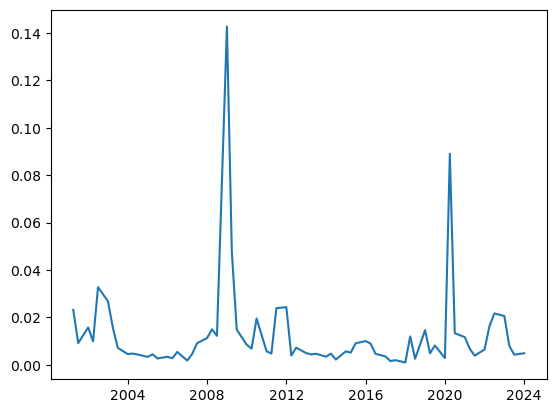

In [206]:
plt.plot(sp500_rv["Quarter_Date_Time"], sp500_rv["log_diff_squared"])

In [207]:
adfuller(sp500_rv["log_diff_squared"])

(-6.4820081539632985,
 1.2880783170128865e-08,
 0,
 68,
 {'1%': -3.530398990560757,
  '5%': -2.9050874099328317,
  '10%': -2.5900010121107266},
 -273.30547781237857)

In [262]:
merged_df = (sp500_rv
 .merge(realized_volatility, on=["Quarter_Date_Time"])
 .merge(avg_q_une_texas, on=["Quarter_Date_Time"])
 .merge(merged_empl_texas, on=["Quarter_Date_Time"])
)

merged_df = merged_df[(merged_df["Quarter_Date_Time"] < "2020")]

In [263]:
merged_df

,Quarter_Date_Time,log_diff_squared,log_diff_squared_2,log_diff_squared_3,log_diff_squared_4,squared_log_diff,squared_log_diff_1,squared_log_diff_2,squared_log_diff_3,squared_log_diff_4,...,ur_lag_3,DATE_x,og_employees,service_employees,ratio,ratio_diff,Year,DATE_y,min_wage,min_w_change
0,2001-04-01,0.023192,0.011030,0.026933,0.002263,0.030440,0.052087,0.084560,0.056632,0.050762,...,4.375,2001-04-01,154.539474,7794.733333,0.019826,0.028972,2001,2001-01-01,3.35,0.000000
1,2001-07-01,0.009209,0.019085,0.011030,0.026933,0.146780,0.030440,0.052087,0.084560,0.056632,...,4.150,2001-07-01,156.450575,7787.333333,0.020090,0.013328,2001,2001-01-01,3.35,0.000000
2,2002-01-01,0.015798,0.023192,0.019085,0.011030,0.057891,0.146780,0.030440,0.052087,0.084560,...,4.275,2002-01-01,148.473145,7757.066667,0.019140,-0.042425,2002,2002-01-01,5.15,0.537313
3,2002-04-01,0.009916,0.009209,0.023192,0.019085,0.029133,0.057891,0.146780,0.030440,0.052087,...,4.900,2002-04-01,146.623356,7777.133333,0.018853,-0.015007,2002,2002-01-01,5.15,0.000000
4,2002-07-01,0.032791,0.015798,0.009209,0.023192,0.031985,0.029133,0.057891,0.146780,0.030440,...,5.700,2002-07-01,145.387817,7785.033333,0.018675,-0.009433,2002,2002-01-01,5.15,0.000000
5,2003-01-01,0.026809,0.009916,0.015798,0.009209,0.053361,0.031985,0.029133,0.057891,0.146780,...,6.225,2003-01-01,144.742399,7794.266667,0.018570,0.000838,2003,2003-01-01,5.15,0.000000
6,2003-04-01,0.015637,0.032791,0.009916,0.015798,0.031013,0.053361,0.031985,0.029133,0.057891,...,6.375,2003-04-01,146.761480,7782.866667,0.018857,0.015435,2003,2003-01-01,5.15,0.000000
7,2003-07-01,0.007184,0.026809,0.032791,0.009916,0.043046,0.031013,0.053361,0.031985,0.029133,...,6.475,2003-07-01,148.308786,7790.100000,0.019038,0.009605,2003,2003-01-01,5.15,0.000000
8,2004-01-01,0.004555,0.015637,0.026809,0.032791,0.040779,0.043046,0.031013,0.053361,0.031985,...,6.775,2004-01-01,150.671518,7872.433333,0.019139,0.006732,2004,2004-01-01,5.15,0.000000
9,2004-04-01,0.004796,0.007184,0.015637,0.026809,0.038091,0.040779,0.043046,0.031013,0.053361,...,6.875,2004-04-01,151.845836,7912.400000,0.019191,0.002703,2004,2004-01-01,5.15,0.000000


In [338]:
model = VAR(merged_df[["ratio_diff", "unemployment rate"]], merged_df[["log_diff_squared", "squared_log_diff_1"]])

In [340]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Apr, 2024
Time:                     13:59:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.1033
Nobs:                     54.0000    HQIC:                  -10.4201
Log likelihood:           147.467    FPE:                2.45199e-05
AIC:                     -10.6190    Det(Omega_mle):     1.92153e-05
--------------------------------------------------------------------
Results for equation ratio_diff
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.002201         0.012472            0.176           0.860
log_diff_squared            -0.292219         0.171574           -1.703           0.089
squared_log_diff_1         

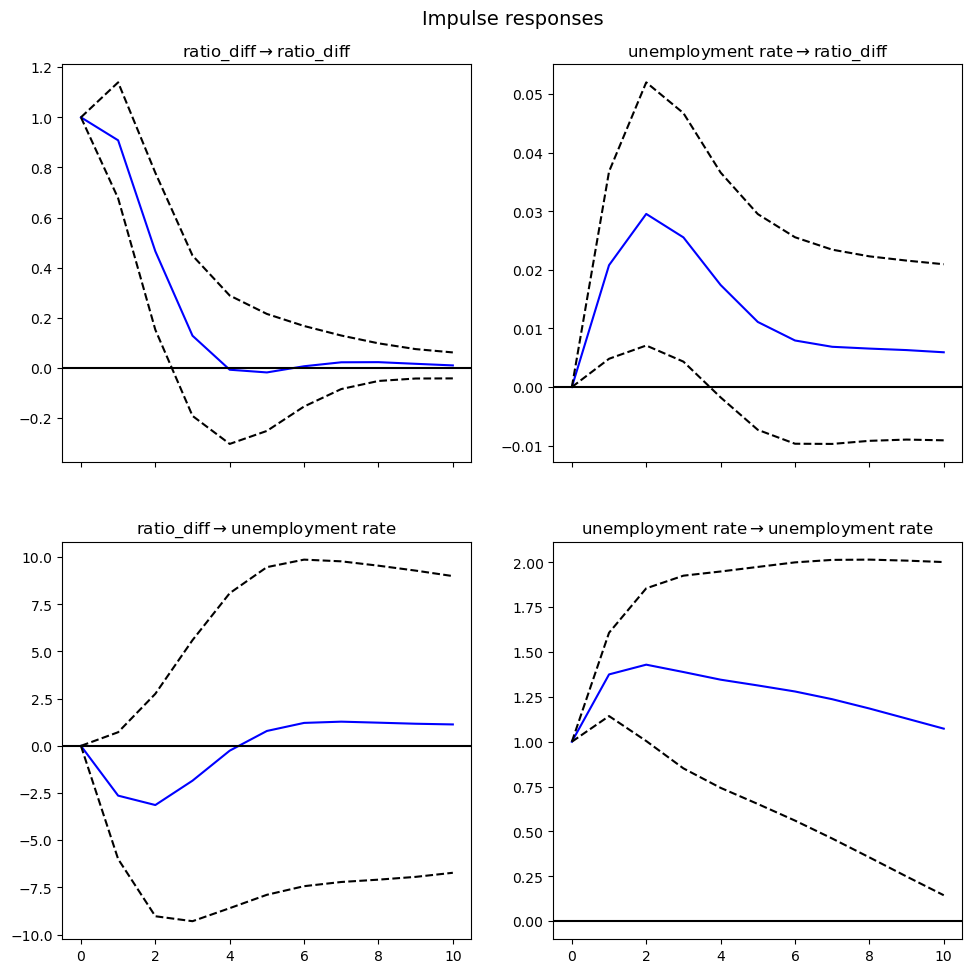

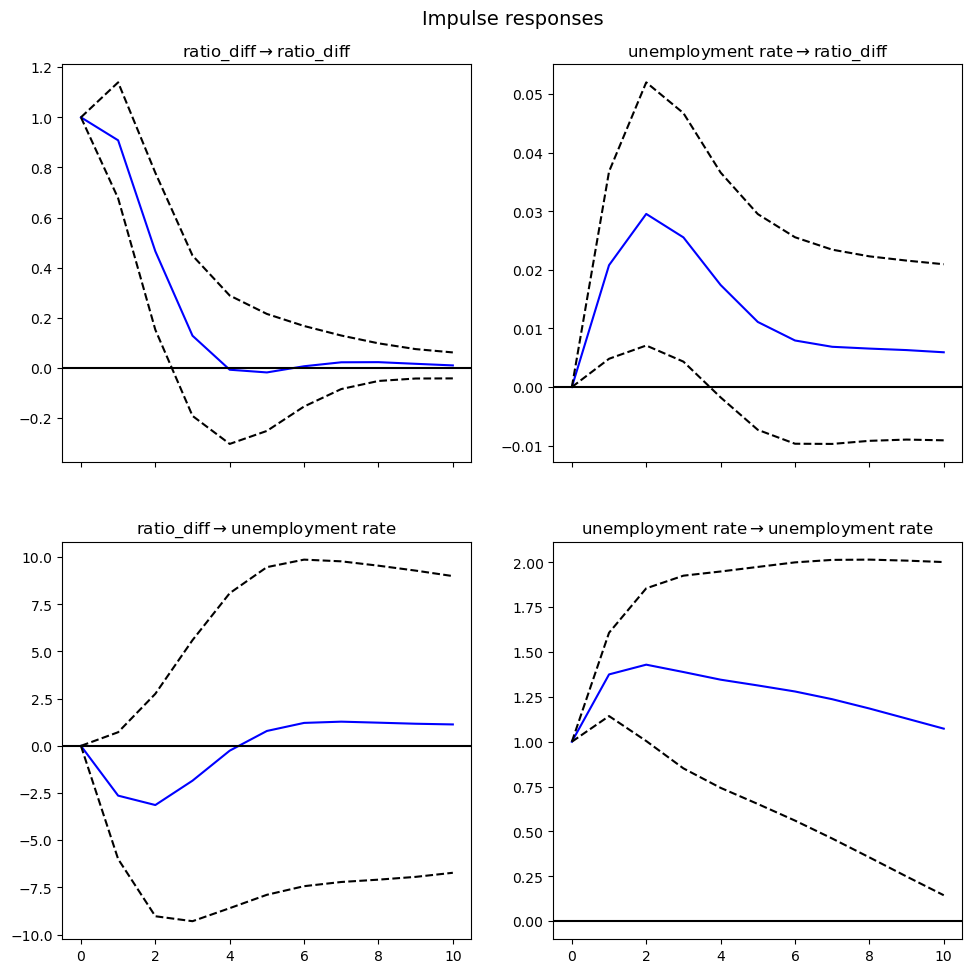

In [341]:
results.irf().plot()

In [319]:
grangercausalitytests(merged_df[["ratio_diff", "squared_log_diff_1"]], maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0341  , p=0.8541  , df_denom=52, df_num=1
ssr based chi2 test:   chi2=0.0361  , p=0.8493  , df=1
likelihood ratio test: chi2=0.0361  , p=0.8493  , df=1
parameter F test:         F=0.0341  , p=0.8541  , df_denom=52, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2641  , p=0.2915  , df_denom=49, df_num=2
ssr based chi2 test:   chi2=2.7863  , p=0.2483  , df=2
likelihood ratio test: chi2=2.7168  , p=0.2571  , df=2
parameter F test:         F=1.2641  , p=0.2915  , df_denom=49, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4932  , p=0.0718  , df_denom=46, df_num=3
ssr based chi2 test:   chi2=8.6177  , p=0.0348  , df=3
likelihood ratio test: chi2=7.9848  , p=0.0463  , df=3
parameter F test:         F=2.4932  , p=0.0718  , df_denom=46, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2915  , p=0.0750  , df_d

{1: ({'ssr_ftest': (0.034132423626310665, 0.8541440913952336, 52.0, 1),
   'ssr_chi2test': (0.036101601912443965, 0.8493058272059517, 1),
   'lrtest': (0.036089758679565875, 0.8493302510851529, 1),
   'params_ftest': (0.03413242362630255, 0.8541440913952458, 52.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.2641344725405619, 0.29153312955163685, 49.0, 2),
   'ssr_chi2test': (2.786255572130218, 0.24829746745295725, 2),
   'lrtest': (2.7167546079285785, 0.2570775974738816, 2),
   'params_ftest': (1.2641344725405534, 0.291533129551638, 49.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.493170281685666, 0.07177229398102182, 46.0, 3),
   'ssr_chi2test': (8.617697278000456, 0.034830280430180355, 3),
   'lrtest': (7.984832087627467, 0.04632622302625836, 3),
   'params_ftest': (2.4931702816856607, 0.07177229398102247, 46.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0